## The Analysis of The Evolution of The Russian Comedy. Other Features

In this analysis,we will explore evolution of the French five-act comedy in verse based on the following two features:
- **The Coefficient of Unused Dramatic Characters** that measures the proportion of the dramatic characters who do not speak in a scene. This was a distinctive feature for tragedy (Iarkho 2006, 448-51)
- **The Percentage of Discontinuous Scenes**, i.e., the scenes where no dramatic character from the preceding scene re-appears on stage in the following scene (Iarkho 2006, 472-4).
    - For example, scene two is a discontinuous scene since it does not share a single dramatic character with scene one: Scene 1. LISA, PRINCE. Scene 2. COUNT.
      
      
We will tackle the following questions:
1. We will explore feature correlations.
2. We will check the features for normality using Shapiro-Wilk normality test. This will help us determine whether parametric vs. non-parametric statistical tests are more appropriate. If the features are not normally distributed, we will use non-parametric tests. 
3. We will run statistical tests to determine whether there are statistically significant differences between the following periods:
 - Period One (from 1775 to 1794)
 - Period Two (from 1795 to 1849).
4. We will create visualizations for each feature.
5. We will run descriptive statistics for each feature.

In [1]:
import pandas as pd
import numpy as np
import json
from os import listdir
from scipy.stats import shapiro
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [2]:
def coefficient_unused_dramatic_characters(data):
    total_present = 0
    total_non_speakers = 0
    for act in data['play_summary'].keys():
        for scene in data['play_summary'][act].keys():
            # identify the raw number of non-speaking dramatic characters
            num_non_speakers = len([item for item in data['play_summary'][act][scene].items() 
                                if (item[1] == 0  or item[1] == 'non_speaking') and item[0] not in ['num_utterances',
                                                                   'num_speakers',
                                                                   'perc_non_speakers']])
            total_non_speakers += num_non_speakers
            # calculate the total number of dramatic characters
            total_present += (data['play_summary'][act][scene]['num_speakers'] + num_non_speakers)
    coefficient_unused = (total_non_speakers / total_present ) * 100        
    
    return coefficient_unused

In [3]:
def get_data(input_directory):
    all_files = [f for f in listdir(input_directory) if f.count('.json') > 0]
    dfs = []
    for file in all_files:
        with open(input_directory + '/' + file) as json_file:
            data = json.load(json_file)
            not_used = coefficient_unused_dramatic_characters(data)
            df = pd.DataFrame([not_used], columns=['coefficient_unused'], index=[file.replace('.json','')])
            dfs.append(df)
            
    features_df = pd.concat(dfs, axis=0, sort=False).round(2)
    
    return features_df

In [4]:
def make_plot(feature, title):
    mean, std, median = summary(feature)
    plt.figure(figsize=(10, 7))
    plt.title(title, fontsize=17)
    sns.distplot(feature, kde=False)
    mean_line = plt.axvline(mean, 
                            color='black',
                            linestyle='solid', 
                            linewidth=2); M1 = 'Mean';
    median_line = plt.axvline(median, 
                               color='green',linestyle='dashdot', 
                               linewidth=2); M2='Median'
    std_line = plt.axvline(mean + std, 
                           color='black',
                           linestyle='dashed', 
                           linewidth=2); M3 = 'Standard deviation';
    plt.axvline(mean - std, 
                color='black',
                linestyle='dashed', 
                linewidth=2)

    plt.legend([mean_line, median_line, std_line], [M1, M2, M3])
    plt.show()

In [5]:
def small_sample_mann_whitney_u_test(series_one, series_two):
    values_one = series_one.sort_values().tolist()
    values_two = series_two.sort_values().tolist()
    # make sure there are no ties  - this function only works for no ties
    result_df = pd.DataFrame(values_one + values_two, columns=['combined']).sort_values(by='combined')
    # average for ties
    result_df['ranks'] = result_df['combined'].rank(method='average')
    # make a dictionary where keys are values and values are ranks
    val_to_rank = dict(zip(result_df['combined'].values, result_df['ranks'].values))
    sum_ranks_one = np.sum([val_to_rank[num] for num in values_one])
    sum_ranks_two = np.sum([val_to_rank[num] for num in values_two])
    # number in sample one and two
    n_one = len(values_one) 
    n_two = len(values_two)
    # calculate the mann whitney u statistic which is the smaller of the u_one and u_two
    u_one = ((n_one * n_two) + (n_one * (n_one + 1) / 2)) - sum_ranks_one
    u_two = ((n_one * n_two) + (n_two * (n_two + 1) / 2)) - sum_ranks_two                     
    # add a quality check 
    assert u_one + u_two == n_one * n_two
    u_statistic = np.min([u_one, u_two])
    
    return u_statistic

In [6]:
def summary(feature):
    mean = feature.mean()
    std = feature.std()
    median = feature.median()
    
    return mean, std, median

In [7]:
# updated boundaries
def determine_period(row):
    if row <= 1794:
        period = 1
    else:
        period = 2
    
    return period

In [8]:
comedies = pd.read_csv('../Russian_Comedies/Data/Comedies_Raw_Data.csv')

In [9]:
# sort by creation date
comedies_sorted = comedies.sort_values(by='creation_date').copy()

In [10]:
# select only original comedies and five act
original_comedies = comedies_sorted[(comedies_sorted['translation/adaptation'] == 0) & 
                                   (comedies_sorted['num_acts'] == 5)].copy()

In [11]:
original_comedies.head()

,index,title,first_name,last_name,creation_date,translation/adaptation,num_acts,free_iambs,num_present_characters,num_scenes_text,...,percentage_open_scenes,percentage_scenes_rhymes_split_verse,num_stage_directions,stage_directions_frequency,num_word_tokens_in_stage_directions,average_length_of_stage_direction,num_verse_splitting_stage_directions,degree_of_verse_prose_interaction,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters
0,R_1,Samoliubivyi stikhotvorets,Nikolai,Nikolev,1775,0,5,0,8,37,...,65.217,17.391,406,24.458,1102,2.714,161,9.699,3,6.667
1,R_2,Khvastun,Iakov,Kniazhnin,1785,0,5,0,14,50,...,47.273,14.545,356,17.298,893,2.508,104,5.053,2,3.636
3,R_4,Prestupnik ot igry ili bratom prodannaia sestra,Dmitrii,Efim’ev,1788,0,5,0,8,43,...,48.077,11.538,299,22.669,782,2.615,90,6.823,5,9.615
2,R_3,Chudaki,Iakov,Kniazhnin,1790,0,5,0,15,44,...,51.667,6.667,386,16.489,1078,2.793,139,5.938,2,3.333
4,R_5,Smekh i gore,Aleksandr,Klushin,1792,0,5,0,9,56,...,6.667,3.333,255,14.522,771,3.024,64,3.645,4,6.667


In [12]:
original_comedies.shape

(16, 38)

In [13]:
# rename column names for clarity
original_comedies = original_comedies.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                      'percentage_non_duologues': 'percentage_non_dialogues',
                                                      'percentage_above_two_speakers': 'percentage_polylogues',
                                                      'percentage_scenes_with_discontinuous_change_characters': 
                                                      'discontinuous_scenes'})

In [14]:
# calculate the coefficient of non-used dramatic characters
unused_coefficient = get_data('../Russian_Comedies/Play_Jsons/')
unused_coefficient['index'] = unused_coefficient.index.tolist()
merged_df = original_comedies.merge(unused_coefficient, on='index')

In [15]:
merged_df.head()

,index,title,first_name,last_name,creation_date,translation/adaptation,num_acts,free_iambs,num_present_characters,num_scenes_text,...,percentage_scenes_rhymes_split_verse,num_stage_directions,stage_directions_frequency,num_word_tokens_in_stage_directions,average_length_of_stage_direction,num_verse_splitting_stage_directions,degree_of_verse_prose_interaction,number_scenes_with_discontinuous_change_characters,discontinuous_scenes,coefficient_unused
0,R_1,Samoliubivyi stikhotvorets,Nikolai,Nikolev,1775,0,5,0,8,37,...,17.391,406,24.458,1102,2.714,161,9.699,3,6.667,12.84
1,R_2,Khvastun,Iakov,Kniazhnin,1785,0,5,0,14,50,...,14.545,356,17.298,893,2.508,104,5.053,2,3.636,18.85
2,R_4,Prestupnik ot igry ili bratom prodannaia sestra,Dmitrii,Efim’ev,1788,0,5,0,8,43,...,11.538,299,22.669,782,2.615,90,6.823,5,9.615,11.32
3,R_3,Chudaki,Iakov,Kniazhnin,1790,0,5,0,15,44,...,6.667,386,16.489,1078,2.793,139,5.938,2,3.333,32.13
4,R_5,Smekh i gore,Aleksandr,Klushin,1792,0,5,0,9,56,...,3.333,255,14.522,771,3.024,64,3.645,4,6.667,13.98


## Part 1. Feature Correlations

In [16]:
# define the features we want to analyze
features = ['coefficient_unused',
            'discontinuous_scenes',
            'num_present_characters', 
            'mobility_coefficient',
            'sigma_iarkho',
            'percentage_monologues', 
            'percentage_non_dialogues', 
            'percentage_polylogues']

In [17]:
merged_df[features].corr()[['coefficient_unused',
                            'discontinuous_scenes']].round(2)

,coefficient_unused,discontinuous_scenes
coefficient_unused,1.00,-0.05
discontinuous_scenes,-0.05,1.00
num_present_characters,0.78,0.01
mobility_coefficient,0.23,-0.38
sigma_iarkho,0.32,0.22
percentage_monologues,-0.35,0.43
percentage_non_dialogues,0.42,0.27
percentage_polylogues,0.46,-0.12


In the corpus of the Russian five-act comedy in verse, the coefficient of unused dramatic characters was strongly positively correlated with the number of dramatic characters (0.78): the more dramatic characters a comedy had, the more likely some of them were not going to be used. It also moderately positively correlated with the percentage of non-dialogues (0.42) and the percentage of polylogues (0.46) and negatively correlated with the percentage of monologues (-0.35). A higher percentage of monologues in a play was associated with a lower coefficient of unused dramatic characters. The coefficient of unused dramatic characters also weakly positively correlated with the mobility coefficient (0.23) and weakly negatively correlated with the percentage of discontinuous scenes (-0.05). 

The percentage of discontinuous scenes was moderately positively correlated with the percentage of monologues (0.43). If there was only one speaker, there were higher odds that they would remain on stage for the next scene. The percentage of discontinuous scenes also mildly correlated with the standard range of the number of speaking characters (0.22) and the percentage of non-dialogues (0.27). It was negatively correlated with the mobility coefficient (-0.38): more scenes did not mean that a higher percentage of them were going to be discontinuous. The percentage of discontinuous scenes moderately negatively correlated with the percentage of polylogues (-0.12). The percentage of discontinuous scenes was almost entirely independent from the number of dramatic characters in a play (0.01) and the coefficient of unused dramatic characters (-0.05).

## Part 2. Feature Distributions and Normality

/opt/anaconda3/envs/text_extraction/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


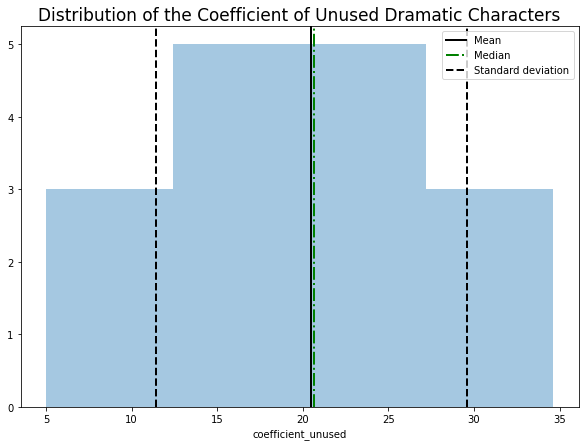

In [18]:
make_plot(merged_df['coefficient_unused'], 
         'Distribution of the Coefficient of Unused Dramatic Characters')

In [19]:
mean, std, median = summary(merged_df['coefficient_unused'])
print('Mean coefficient of unused dramatic characters', round(mean, 2))
print('Standard deviation of the coefficient of unused dramatic characters:', round(std, 2))
print('Median coefficient of unused dramatic characters:', median)

Mean coefficient of unused dramatic characters 20.51
Standard deviation of the coefficient of unused dramatic characters: 9.1
Median coefficient of unused dramatic characters: 20.64


### Shapiro-Wilk Normality Test

In [20]:
print('The p-value of the Shapiro-Wilk normality test:', 
      shapiro(merged_df['coefficient_unused'])[1])

The p-value of the Shapiro-Wilk normality test: 0.7443241477012634


The Shapiro-Wilk test showed that the probability of the coefficient of dialogue vivacity of being normally distributed is 0.7443241477012634, which is much higher than the 0.05 significance level. We fail to reject the null hypothesis of the normal distribution.

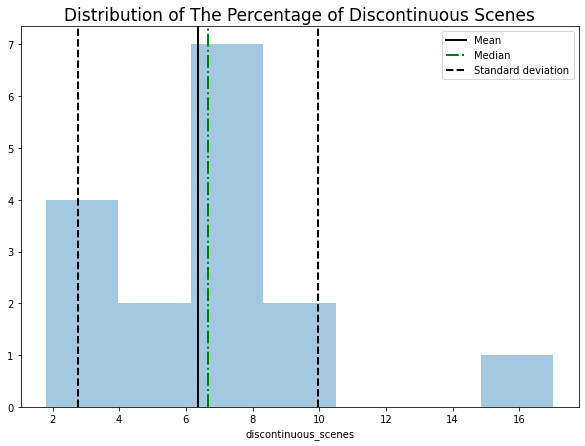

In [21]:
make_plot(merged_df['discontinuous_scenes'], 
         'Distribution of The Percentage of Discontinuous Scenes')

In [22]:
mean, std, median = summary(merged_df['discontinuous_scenes'])
print('Mean percentage of discontinuous scenes', round(mean, 2))
print('Standard deviation of the percentage of discontinuous scenes:', round(std, 2))
print('Median percentage of discontinuous scenes:', round(median, 2))

Mean percentage of discontinuous scenes 6.37
Standard deviation of the percentage of discontinuous scenes: 3.61
Median percentage of discontinuous scenes: 6.67


In [23]:
print('The p-value of the Shapiro-Wilk normality test:', 
      shapiro(merged_df['discontinuous_scenes'])[1])

The p-value of the Shapiro-Wilk normality test: 0.011422311887145042


The Shapiro-Wilk showed that the probability of the percentage of scenes with split verse lines of being normally distributed is low (the p-value is 0.011422311887145042). Since it is below the 0.05 significance level, we reject the null hypothesis of normal distribution.

### Summary:
1. The coefficient of unused dramatic characters is normally distributed. For this feature, we can use a parametric statistical test.
2. The percentage of discontinuous scenes is not normally distributed. For this feature, we will use a non-parametric test such as the Mann-Whitney test.

## Part 3. Hypothesis Testing

We ran statistical tests to determine whether the two periods distinguishable for the Russian five-act verse comedy were significantly different for the Russian five-act comedy. The two periods were:
 - Period One (from 1747 to 1794)
 - Period Two (from 1795 to 1822)
 
For the coefficient of unused dramatic characters that was normally distributed, we used scipy.stats Python library to run a t-test to check whether there was a difference between the distribution of the feature in Period One and Period Two. The null hypothesis was that no difference between the two periods. The alternative hypothesis was that the feature distribution in two periods would be different. Our significance level was set at 0.05. If the p-value produced by the t-test were below 0.05, we would reject the null hypothesis of no difference.


For the percentage of scenes with split rhymes and verse lines, we will run **the Mann-Whitney u-test** to check whether there is a difference between Period One and Period Two. The null hypothesis will be no difference between these periods, whereas the alternative hypothesis will be that the periods will be different.

For the percentage of discontinuous scenes, we ran the Mann-Whitney u-test to check whether there was a difference between the feature distribution in Period One and Period Two. The null hypothesis was no difference between these periods, whereas the alternative hypothesis was that the periods would differ. Since most of the periods had fewer than 20 tragedies, we could use the scipy’s Mann-Whitney u-test that required each sample size to be at least 20 because it used normal approximation. Instead, we had to run Mann-Whitney U-test without a normal approximation for which we wrote a custom function. The details about the test can be found in the following resource: https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/bs704_nonparametric4.html.

One limitation that we need to mention is the sample size. The first period has only six comedies and the second period has only ten. However, it is impossible to increase the sample size - we cannot ask the Russian playwrights of the eighteenth and nineteenth century to produce more five-act verse comedies. If there are other Russian five-act comedies of these periods, they are either unknown or not available to us.

In [24]:
merged_df['period'] = merged_df.creation_date.apply(determine_period)

In [25]:
period_one = merged_df[merged_df['period'] == 1].copy()
period_two = merged_df[merged_df['period'] == 2].copy()

In [26]:
period_one.shape

(6, 40)

In [27]:
period_two.shape

(10, 40)

## The T-Test

### The Coefficient of Unused Dramatic Characters

In [28]:
from scipy.stats import ttest_ind

In [29]:
ttest_ind(period_one['coefficient_unused'],
          period_two['coefficient_unused'], equal_var=False)

Ttest_indResult(statistic=-0.5151761573646824, pvalue=0.6154717400806438)

### Summary

|Feature                    |p-value               |Result
|---------------------------| ----------------|--------------------------------
|  The coefficient of unused dramatic characters |0.62 | Not Significant


## The Mann-Whitney Test

The Process:
- Our null hypothesis is that there is no difference between two periods. Our alternative hypothesis is that the periods are different.
- We will set the signficance level (alpha) at 0.05.
- We will run the test and calculate the test statistic.
- We will compare the test statistic with the critical value of U for a two-tailed test at alpha=0.05. Critical values can be found at https://www.real-statistics.com/statistics-tables/mann-whitney-table/.
- If our test statistic is equal or lower than the critical value of U, we will reject the null hypothesis. Otherwise, we will fail to reject it.

### The Percentage of Scenes With Split Verse Lines and Rhymes

In [30]:
small_sample_mann_whitney_u_test(period_one['discontinuous_scenes'],
                                 period_two['discontinuous_scenes'])

27.0

### Critical Value of U

|Periods                      |Critical Value of U              
|---------------------------| ----------------
|  Period One (n=6) and Period Two (n=10) |11


### Summary

|Feature                    |u-statistic              |Result
|---------------------------| ----------------|--------------------------------
|  The percentage of discontinuous scenes|27 | Not Significant

Based on such features at the coefficient of unused dramatic characters and the percentage of discontinuous scenes, there are no significant differences between the two periods.

## Part 4. Visualizations

In [31]:
def scatter(df, feature, title, xlabel, text_y):
    sns.jointplot('creation_date', 
               feature,
               data=df, 
               color='b', 
               height=7).plot_joint(
               sns.kdeplot, 
               zorder=0, 
               n_levels=20)
    plt.axvline(1795, color='grey',linestyle='dashed', linewidth=2)
    plt.text(1795.5, text_y, '1795')
    plt.title(title, fontsize=20, pad=100)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(xlabel, fontsize=14)

    plt.show()

### The Coefficient of Unused Dramatic Characters

/opt/anaconda3/envs/text_extraction/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


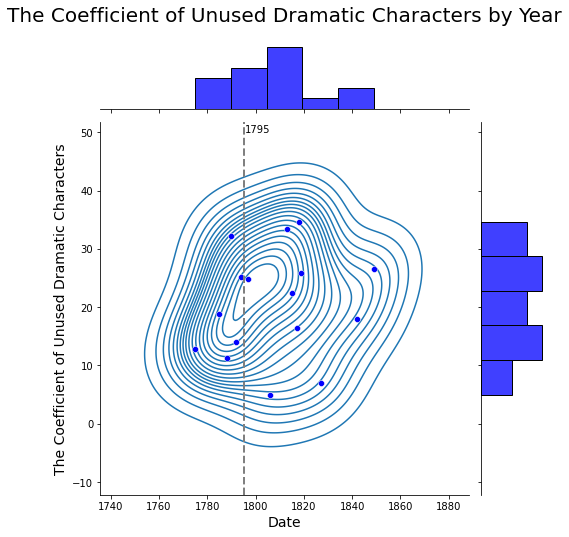

In [32]:
scatter(merged_df, 
        'coefficient_unused', 
        'The Coefficient of Unused Dramatic Characters by Year', 
        'The Coefficient of Unused Dramatic Characters',
        50)

### The Percentage of Discontinuos Scenes

/opt/anaconda3/envs/text_extraction/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


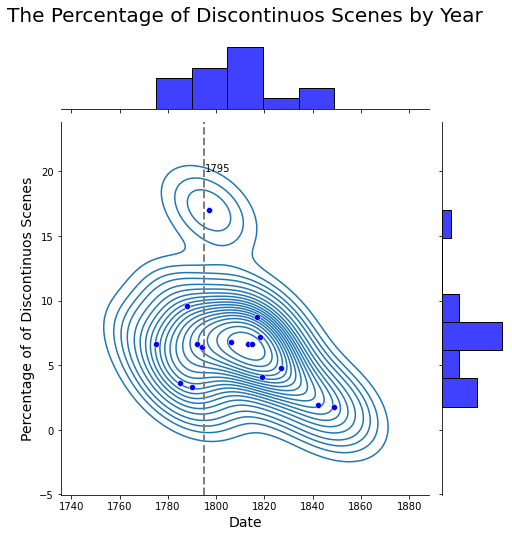

In [33]:
scatter(merged_df, 
        'discontinuous_scenes', 
        'The Percentage of Discontinuos Scenes by Year', 
        'Percentage of of Discontinuos Scenes',
         20)

## Part 5. Descriptive Statistics For Two Periods and Overall

### The Coefficient of Dialogue Vivacity

#### In Entire Corpus

In [34]:
merged_df.describe().loc[:, 'coefficient_unused'][['mean', 
                                                    'std', 
                                                    '50%',
                                                    'min', 
                                                    'max']].round(2)

mean    20.51
std      9.10
50%     20.64
min      5.00
max     34.63
Name: coefficient_unused, dtype: float64

#### By  Tentative Periods

In [35]:
merged_df.groupby('period').describe().loc[:, 'coefficient_unused'][['mean', 
                                                                                'std', 
                                                                                '50%',
                                                                                'min', 
                                                                                'max']].round(2)

,mean,std,50%,min,max
period,,,,,
1,19.04,8.15,16.42,11.32,32.13
2,21.40,9.95,23.64,5.00,34.63


### The Percentage of Discontinuous Scenes

#### In Entire Corpus

In [36]:
merged_df.describe().loc[:, 'discontinuous_scenes'][['mean', 
                                                    'std', 
                                                    '50%',
                                                    'min', 
                                                    'max']].round(2)

mean     6.37
std      3.61
50%      6.67
min      1.80
max     17.02
Name: discontinuous_scenes, dtype: float64

#### By Tentative Periods

In [37]:
merged_df.groupby('period').describe().loc[:,'discontinuous_scenes'][['mean', 
                                                                    'std', 
                                                                    '50%',
                                                                    'min', 
                                                                    'max']].round(2)

,mean,std,50%,min,max
period,,,,,
1,6.05,2.31,6.52,3.33,9.62
2,6.55,4.32,6.67,1.80,17.02


### Summary:
1. In the corpus of the Russian five-act comedy in verse, the mean coefficient of unused dramatic characters was 20.51, with a standard deviation of 9.10. In the tentative Period One, the mean coefficient of unused dramatic characters was 19.04, with a standard deviation of 8.15. In Period Two, it increased to 21.40, with a standard deviation of 9.95.

2. The mean percentage of discontinuous scenes was 30.39%, with a standard deviation of 14.39%. In the tentative Period One, the mean was 6.05, with the standard deviation of 2.31. In the tentative Period Two, the mean percentage of discontinuous scenes was 6.55, with a standard deviation of 6.67. However, looking at the visualizations and the natural clustering in the data, it appears that **1805** is a more appropriate boundary for the two periods.


## Conclusions:
1. The coefficient of unused dramatic characters was normally distributed whereas the percentage of discontinuous scenes was not.
2. Both the coefficient of unused dramatic characters and the percentage of discontinuous scenes have increased from Period One (from 1775 to 1794) to Period Two (from 1795 to 1849), as did their standard deviations.
3. We propose an alternative potential boundary between the two periods in 1805.